In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import IPython
from mpl_toolkits.axes_grid1 import make_axes_locatable
from misc import reportProgress
from scipy.ndimage.filters import gaussian_filter
from misc import round_sig_str as round_sig_str

In [2]:
np.version.full_version

'1.19.1'

In [3]:
pixels = 128
photons = 3
avgPhotonsPerImage = 30
QE = 0.9
darkElectronChance = 0.0003
seed = 42
rs = np.random.RandomState(seed)
background = 1

In [4]:
def reportProgress(num, total):
    print( round_sig_str(num/total*100) + '%                     ',  end='\r' )
    IPython.display.clear_output(wait=True)

In [5]:
def gaus(x, m, s):
    return (1/(s*np.sqrt(2*np.pi))*np.exp(-(x-m)**2/(2*s**2)))                            

xx, yy = np.meshgrid(np.arange(128), np.arange(128))
gaus2d = avgPhotonsPerImage*gaus(xx, 64, 5)*gaus(yy, 64, 5)

In [6]:
x = np.arange(1000)

def gain(x): 
    return np.exp(-0.009*x)

gain_pdf=gain(x)

#print(np.random.choice(x, p=gain_pdf/sum(gain_pdf)))

In [8]:
#binHeights, binEdges = np.histogram(np.random.choice(x, p=gain_pdf/sum(gain_pdf), size=int(1e6)), bins=100)
#plt.step(binEdges[:-1], binHeights)

In [9]:
def getSimulatedImage():
    
    image = np.zeros((128, 128))
    photonImage = np.zeros((128, 128))
    
#Blur the Gaussian-distributed photon image   
    #blurred = gaussian_filter(gaus2d, 3)
    #for rowi, row in enumerate(image):
     #   for coli, col in enumerate(row):
            #filterSigma = getFilterSigma(row,col)
      #      filterSigma = 25
       #     intensityDist = gaus2d[rowi,coli]
        #    image += gaussian(intensityDist, x=row, y=col, x0=64, y0=64, sigma=filterSigma)
        
#This loop applies a Poisson-distributed shotnoise.        
    for rowi, row in enumerate(image):
        for coli, col in enumerate(row):
            meanIntensity = gaus2d[rowi, coli]
            #sample from blurred gaussian
            shotnoise = rs.poisson(meanIntensity)

            photonImage[rowi, coli] += shotnoise
            
#This loops calculates nuber of electrons accounting for QE, dark electrons, EM gain noise, and readout noise.
    for rowi, row in enumerate(image):
        for coli, col in enumerate(row):
            numPhotons = photonImage[rowi, coli]
            numElectrons = numPhotons*QE
#random chance to find a "Dark electron"           
            if np.random.random() < darkElectronChance:
                numElectrons += 1                
                
#EM gain amplification: using 1 distribution, sampling from it as many times as there are electrons on a pixel.
            if numElectrons == 0:
                electronsGained = 0
            elif numElectrons == 1:
                ElectronsOut = np.random.choice(x, p=gain_pdf/sum(gain_pdf))
                electronsGained = ElectronsOut
            else:
                ElectronsOut = np.random.choice(x, size=int(numElectrons), p=gain_pdf/sum(gain_pdf))
                electronsGained = sum(ElectronsOut)
                
                
            readOutNoise = np.random.randint(0, 20)
            counts = electronsGained + readOutNoise

            image[rowi, coli] += counts
            
    return image

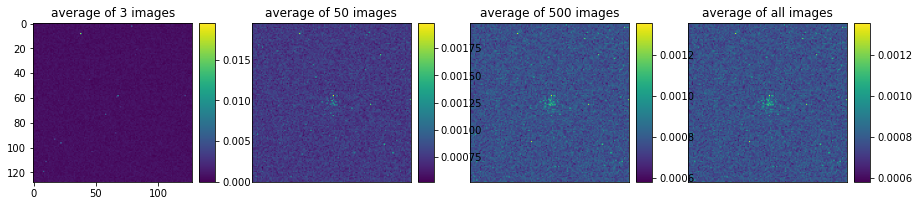

In [10]:
imageSeries = []

for imageNum in range(100):
    imageSeries.append(getSimulatedImage())
    reportProgress(imageNum, 100)

avgImage3 = np.mean(imageSeries [:3], 0)
avgImage25 = np.mean(imageSeries [:50], 0)
avgImage50 = np.mean(imageSeries [:100], 0)
avgImage = np.mean(imageSeries,0)


normalizedImage3 = avgImage3/(111**2)
normalizedImage25 = avgImage25/(111**2)
normalizedImage50 = avgImage50/(111**2)
normalizedImage = avgImage/(111**2)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=[15, 15])

img0 = ax0.imshow(normalizedImage3)
ax0.set_title('average of 3 images')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="10%", pad=0.10)
cb0 = plt.colorbar(img0, cax=cax)

img1 = ax1.imshow(normalizedImage25)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('average of 50 images')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="10%", pad=0.10)
cb = plt.colorbar(img1, cax=cax)

img2 = ax2.imshow(normalizedImage50)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('average of 500 images')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="10%", pad=0.10)
cb = plt.colorbar(img2, cax=cax)

img3 = ax3.imshow(normalizedImage)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('average of all images')

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="10%", pad=0.10)
cb = plt.colorbar(img3, cax=cax)

plt.show()

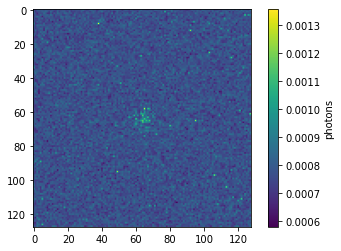

In [11]:
plt.imshow(normalizedImage)
cax = plt.colorbar(label='photons')